In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, Tracker, SmoothL1GiouLoss

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
rpn_tk = Tracker()

In [3]:
ALPHA = 0.6
BETA = 0.4

### Monitoring and CUDA Setup


In [4]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_23_2024_104831'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
rpn_tk.date = rn
rpn_tk.logfile = f'rpn_vit_{dte}.log'
rpn_tk.device = device

### Config for RPN and ViT Fitter


In [7]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': SmoothL1GiouLoss.loss,
    'lr': 0.0001
}

324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config
rpn_tk.uses_resnet = rpn_config['model'].config['pretrained']
rpn_tk.optimizer = f"{rpn_config['optimizer']}"
rpn_tk.epochs = rpn_config['epochs']
rpn_tk.lr = rpn_config['lr']
rpn_tk.loss = f"""
    {rpn_config['loss']}
    alpha: {ALPHA}
    beta: {BETA}
"""

### Dataset Loading


In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [10]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
rpn_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1,1,928.405273,35
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1,1,928.405273,35
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1,1,928.405273,35
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1,1,928.405273,35
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,241.000000,36
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1,3,241.000000,36
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1,3,448.000000,39
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [11]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 rpn_tracker=rpn_tk,
                ):
    if cohort == 1:
        rpn_tracker.cohort1 = True
    if cohort == 2:
        rpn_tracker.cohort2 = True
    if cohort == 3:
        rpn_tracker.cohort3 = True
    
    rpn_tracker.test_size = test_size
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [12]:
from project import Fitter

In [13]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses= self.loss(pred= torch.stack(Y), target = torch.stack(T), alpha=ALPHA, beta=BETA)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses= self.loss(pred= torch.stack(Y), target = torch.stack(T), alpha=ALPHA, beta=BETA)
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

### Train-Test Split


In [14]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [15]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001F1FF6C3E20>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000001F1FF6C14B0>


In [16]:
batchs = 15

rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [17]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [19]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [20]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

In [21]:
rpn_fold_metrics = []

fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)

    rpn_tk.batch_size = 15
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')

    

INFO:kess:################################### Fold 1/5 ###################################


Fold 1/5
324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cud

Fold 2/5
324


INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3276568055152893

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.30482372641563416

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.2503923773765564

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	13
INFO:kess:Current error:	0.1799062192440033

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.004932857431664035
INFO:kess:Avg Precision: 0.02933553375046829
INFO:kess:Avg Recall: 0.005597755979296976
INFO:kess:Avg F1: 0.007721454475139235
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.07837224751710892

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.10019733756780624

INFO:kess:Batch:	3/4
INFO:kess:Batch 

Fold 3/5
324


INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3329932391643524

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3413955271244049

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.29452571272850037

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	13
INFO:kess:Current error:	0.27643048763275146

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.0003478688765959493
INFO:kess:Avg Precision: 0.034482758620689655
INFO:kess:Avg Recall: 0.0003478688765959493
INFO:kess:Avg F1: 0.000688400569147077
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.1832275688648224

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.06587546318769455

INFO:kess:Batch:	3/4
INFO:kess:Bat

Fold 4/5
324


INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.32308506965637207

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3173185884952545

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.30757153034210205

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	14
INFO:kess:Current error:	0.2932697534561157

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.11585445002005515
INFO:kess:Avg Precision: 0.32171080002592783
INFO:kess:Avg Recall: 0.18972740533082919
INFO:kess:Avg F1: 0.18008617753699674
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.24099483474024705
INFO:kess:Avg Precision: 0.28785701814506737
INFO:kess:Avg Recall: 0.6294330001941749
INFO:kess:Avg F1: 0.3659180871077946
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.28003862500190735

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error

Fold 5/5
324


INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3102813959121704

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.3146161437034607

INFO:kess:Batch:	3/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.28234538435935974

INFO:kess:Batch:	4/4
INFO:kess:Batch samples:	14
INFO:kess:Current error:	0.27776455879211426

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.19075378943708235
INFO:kess:Avg Precision: 0.3703261305088714
INFO:kess:Avg Recall: 0.36599370793802505
INFO:kess:Avg F1: 0.29194700967331055
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.20156215876340866
INFO:kess:Avg Precision: 0.20794809822525298
INFO:kess:Avg Recall: 0.9021492855889457
INFO:kess:Avg F1: 0.3264135005218642
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	0.2828211486339569

INFO:kess:Batch:	2/4
INFO:kess:Batch samples:	15
INFO:kess:Current error:	

In [22]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

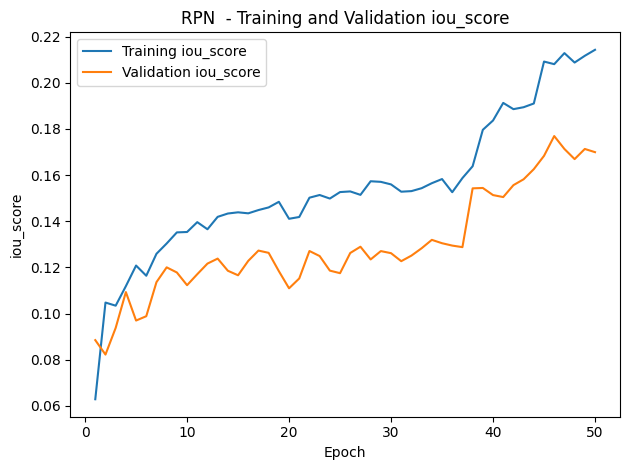

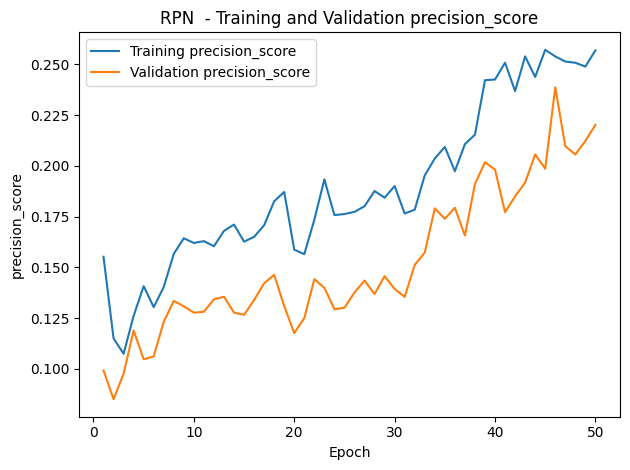

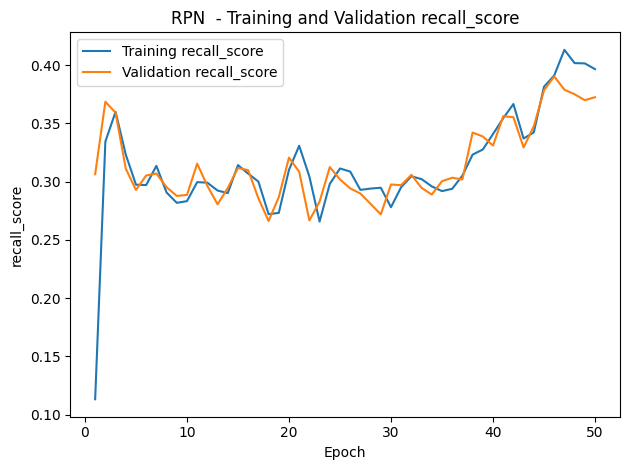

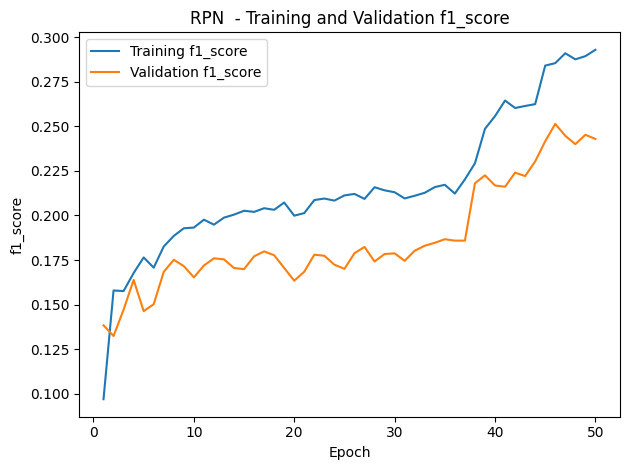

In [25]:
rpn_metrics = ['iou_score', 'precision_score', 'recall_score', 'f1_score']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

### Loss History Visualization


In [26]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

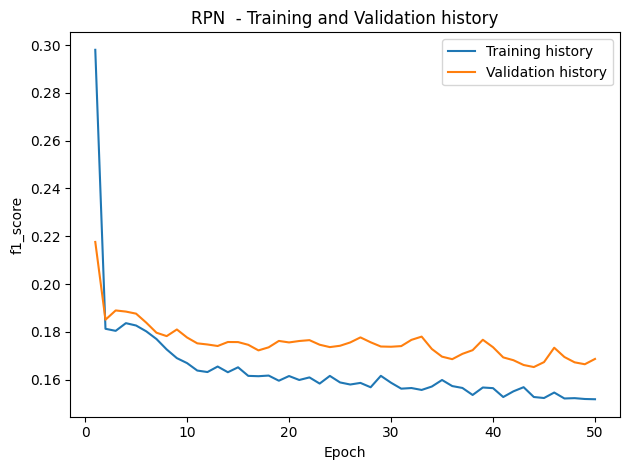

In [27]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
# plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### RPN


In [28]:
df_rpn_metrics = pd.DataFrame(columns=['fold', 'iou', 'precision', 'recall', 'f1'])
df_rpn_metrics

,fold,iou,precision,recall,f1


In [29]:
df_rpn_metrics['fold'] = [1, 2, 3, 4, 5]
df_rpn_metrics['iou'] = rpn_test_iou
df_rpn_metrics['precision'] = rpn_test_precision
df_rpn_metrics['recall'] = rpn_test_recall
df_rpn_metrics['f1'] = rpn_test_f1

In [30]:
rpn_tk.iou = df_rpn_metrics.iou.mean()
rpn_tk.precision = df_rpn_metrics.precision.mean()
rpn_tk.recall = df_rpn_metrics.recall.mean()
rpn_tk.f1 = df_rpn_metrics.f1.mean()

In [31]:
df_rpn_metrics

,fold,iou,precision,recall,f1
0,1,0.136164,0.197246,0.335322,0.201233
1,2,0.000000,0.000000,0.000000,0.000000
2,3,0.132177,0.149996,0.308029,0.194032
3,4,0.285167,0.355973,0.568955,0.413959
4,5,0.283420,0.328856,0.649571,0.414834


In [32]:
rpn_iou_score = np.array(rpn_test_iou).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()

print('RPN Test Set Performance Metrics')
print(f'Average IOU: {rpn_iou_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')

RPN Test Set Performance Metrics
Average IOU: 0.16738566729044052 
Average Precision: 0.20641410554710188 
Average Recall: 0.37237536667993193 
Average F1 Score: 0.24481166978611757 


In [33]:
df_rpn_metrics.to_csv(f'{fold_dir}/rpn_metrics.csv')

In [34]:
df_rpn_metrics.to_csv(f'./statistical-treatment/isa-rpn.csv')

### Sample


In [35]:
import matplotlib.patches as patches

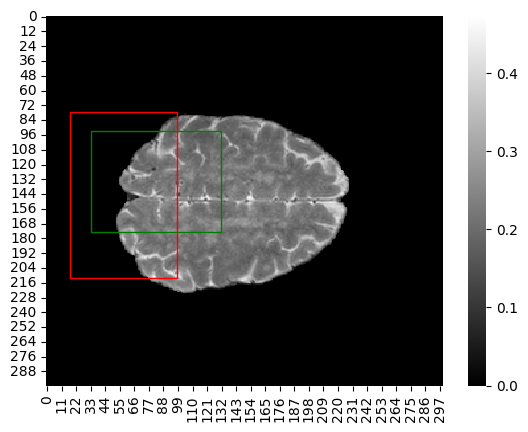

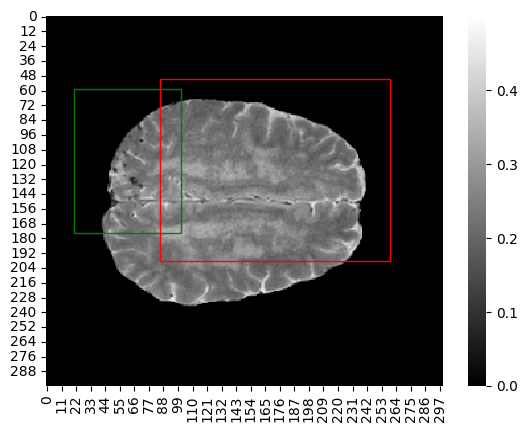

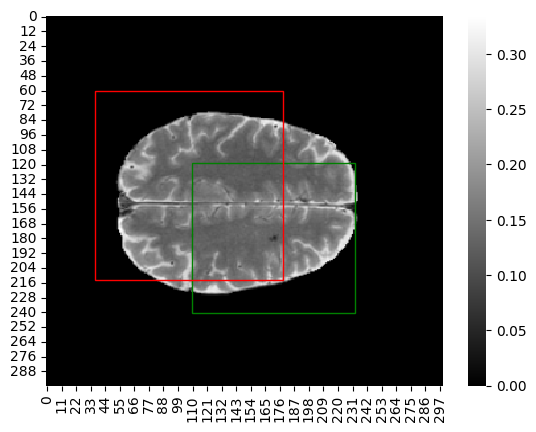

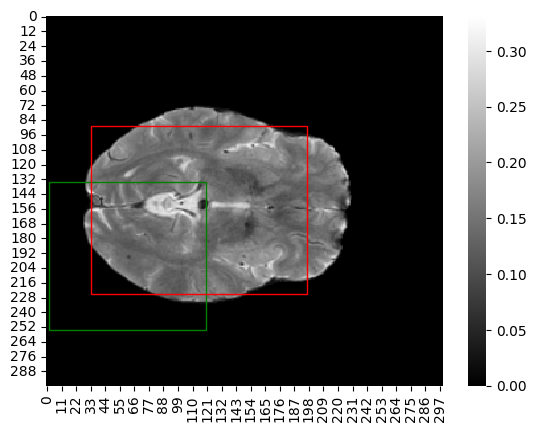

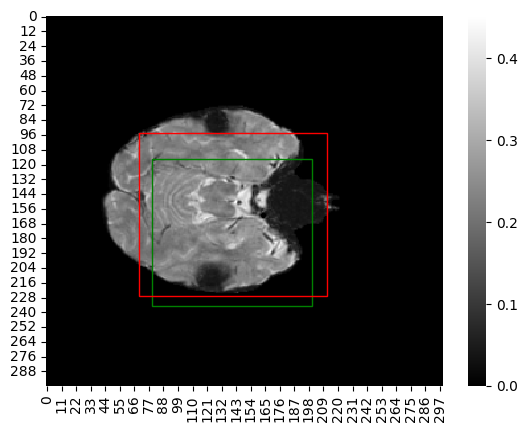

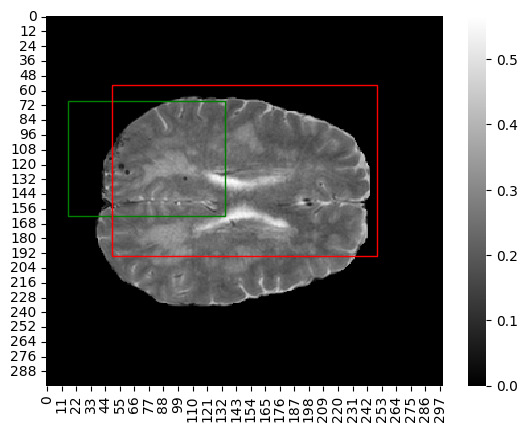

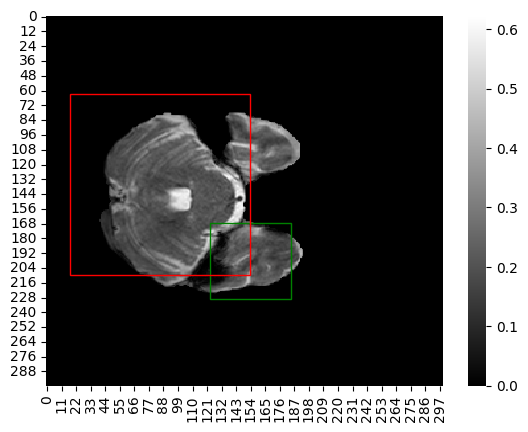

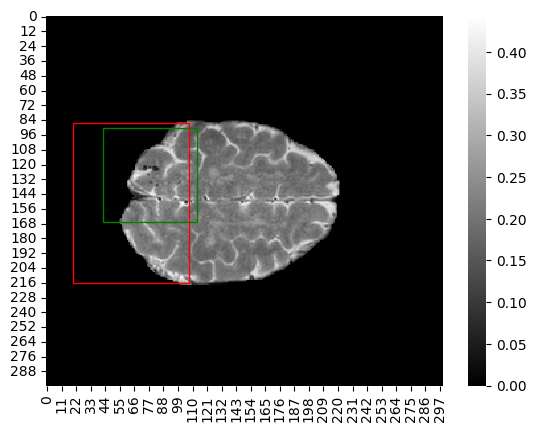

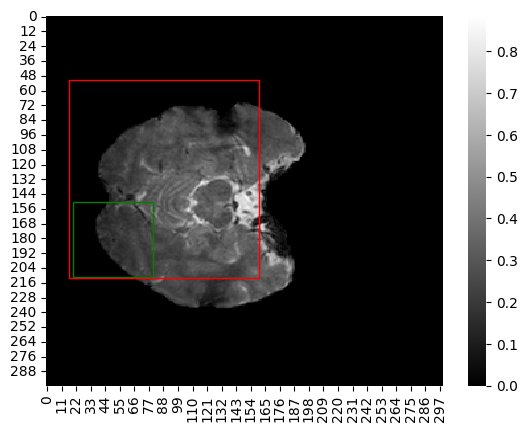

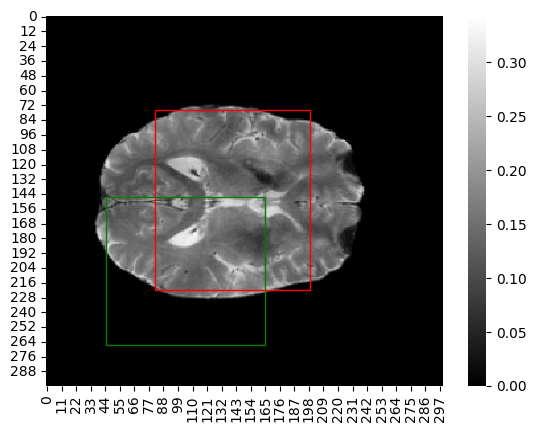

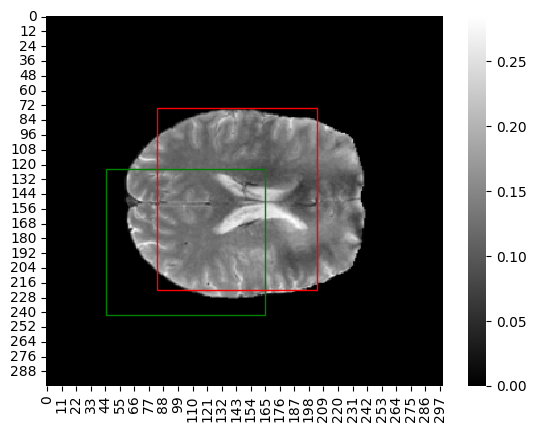

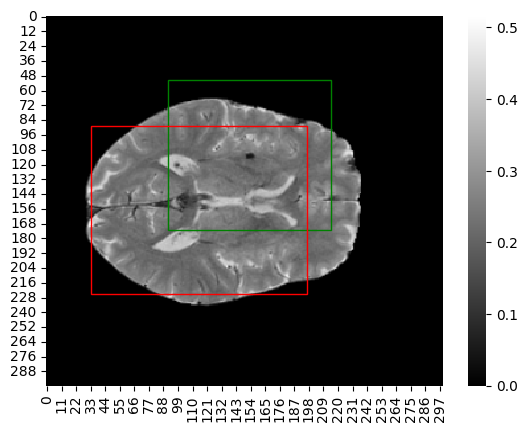

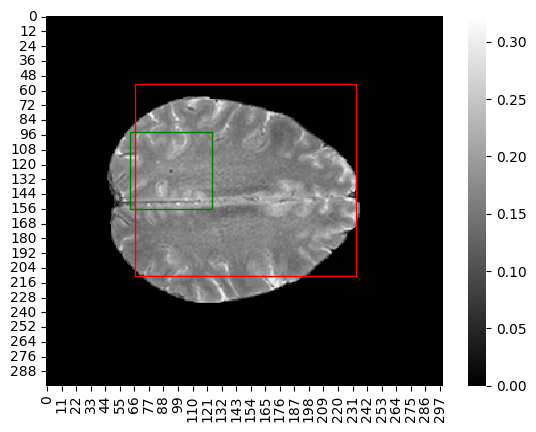

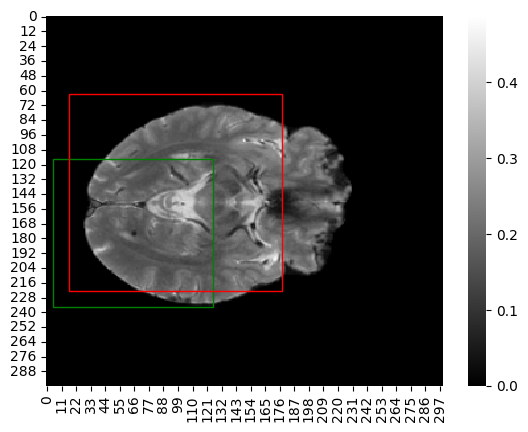

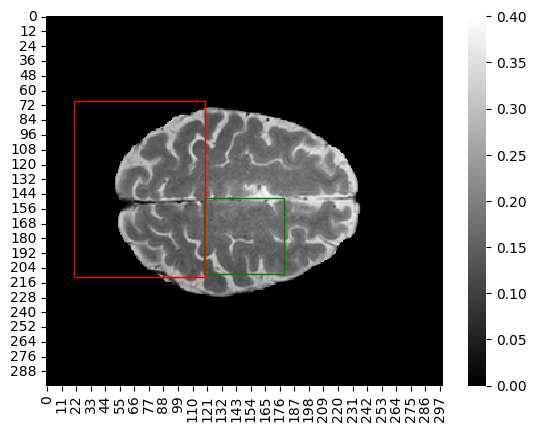

In [36]:
sample = next(iter(rpn_test_dataloader))

for i in range(len(next(iter(rpn_test_dataloader)))):
    rpn_slices, rpn_masks, rpn_target, rpn_case = sample[i]
    
    rpn_x = rpn_slices.squeeze(1).float().to(device)
    rpn_T = rpn_masks.squeeze(1).float().to(device)
    rpn_y = rpn_fitter.model(rpn_x, rpn_target)
    
    rpn_fitter.loss(rpn_y, rpn_T[rpn_target])
    rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
    rpn_y = (rpn_y*300).squeeze().detach().cpu().long()
    
    ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

    truth = patches.Rectangle(
        (rpn_bbox[0], rpn_bbox[1]),
        rpn_bbox[2] - rpn_bbox[0],
        rpn_bbox[3] - rpn_bbox[1],
        linewidth=1, edgecolor='g', facecolor='none'
    )

    pred = patches.Rectangle(
        (rpn_y[0], rpn_y[1]),
        rpn_y[2] - rpn_y[0],
        rpn_y[3] - rpn_y[1],
        linewidth=1, edgecolor='r', facecolor='none'
    )

    ax.add_patch(truth)
    ax.add_patch(pred)
    plt.show()

# Log Progress


In [37]:
rpn_tk.notes = '''
Global Context
'''

In [38]:
rpn_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-23 10:48:31.227962,RPN,None,None,False,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,0.372375,0.244812,None,None,None,None,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",rpn_vit_Nov_23_2024_104831.log,cuda,\nGlobal Context\n


In [39]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, rpn_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    rpn_tk().to_csv('history/runs.csv')

Making new csv file
